# Ensemble Models

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    BaggingClassifier, AdaBoostClassifier, VotingClassifier,
    StackingClassifier, RandomForestClassifier
)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Ensemble Learning Overview

The table below summarizes the key differences between the main types of ensemble learning techniques, highlighting how they train and combine multiple models to improve overall performance:

| **Aspect** | **Bagging** | **Boosting** | **Voting** | **Stacking** |
| ---------- | ----------- | ------------ | ---------- | ------------ |
| **Base models** | Same type (homogeneous) | Weak learners (often trees) | Different types (heterogeneous) | Different types (heterogeneous) |
| **Training style** | Parallel, independent | Sequential, dependent | Parallel, independent | Two-stage (meta-learner on top) |
| **Combination rule** | Averaging / majority vote | Weighted sum of models | Averaging / majority vote | Meta-model learns optimal combination |
| **Main goal** | Reduce variance | Reduce bias (and variance) | Aggregate diverse models | Learn how to best combine models |
| **Example** | Random Forest | AdaBoost, XGBoost, LightGBM | VotingClassifier / VotingRegressor | StackingClassifier / StackingRegressor |

In [2]:
df = load_breast_cancer(as_frame=True).frame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [4]:
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))

In [6]:
bag = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50)

boost = AdaBoostClassifier(n_estimators=50)

vote = VotingClassifier(estimators=[
    ("knn", knn),
    ("lr", lr),
    ("tree", DecisionTreeClassifier()),
    ("naive", GaussianNB())
], voting="soft")

stack = StackingClassifier(
    estimators=[
        ("knn", knn),
        ("lr", lr),
        ("tree", DecisionTreeClassifier()),
        ("naive", GaussianNB())
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)

models = {"Bagging": bag, "Boosting": boost, "Voting": vote, "Stacking": stack}

In [7]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {name}\t| Accuracy: {accuracy * 100:.2f}%")

Model: Bagging	| Accuracy: 93.86%
Model: Boosting	| Accuracy: 95.61%
Model: Voting	| Accuracy: 96.49%
Model: Stacking	| Accuracy: 97.37%


## Random Forest

Random Forest is an ensemble learning method based on the principle of **bagging** (bootstrap aggregation).  
It builds multiple decision trees on random subsets of data and averages their predictions to improve generalization and reduce overfitting.

### 1. Row sampling (Bootstrap)

For each tree $t$, we randomly sample rows **with replacement** from the training data:

$$
D_t = \{ (x_i, y_i) \}_{i=1}^{N}, \quad (x_i, y_i) \sim D
$$

where  

* $N$ — total number of rows in the original dataset,  
  meaning each bootstrap sample has the **same size** as the full dataset, but may include **repeated rows**.

### 2. Feature sampling (Random subset of attributes)

At each split of a tree, a random subset of features is selected:

$$
m =
\begin{cases}
\sqrt{M}, & \text{for classification} \\
\frac{M}{3}, & \text{for regression}
\end{cases}
$$

where  

* $M$ — total number of available features,  
* $m$ — number of features considered at each split.

### 3. Model aggregation (Ensemble prediction)

Once all trees are trained, their predictions are combined:

$$
\hat{y} =
\begin{cases}
\operatorname{mode}\!\left(\hat{y}_1, \hat{y}_2, \dots, \hat{y}_T\right), & \text{for classification} \\
\dfrac{1}{T}\sum\limits_{t=1}^{T} \hat{y}_t, & \text{for regression}
\end{cases}
$$

where  

* $T$ — total number of trees in the forest,  
* $\hat{y}_t$ — prediction made by the $t$-th tree.

### Summary

By combining multiple weakly correlated trees, Random Forest achieves **high accuracy**, **low variance**,  
and **strong resistance to overfitting**, while requiring minimal hyperparameter tuning.

In [8]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [9]:
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy: 95.61%
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



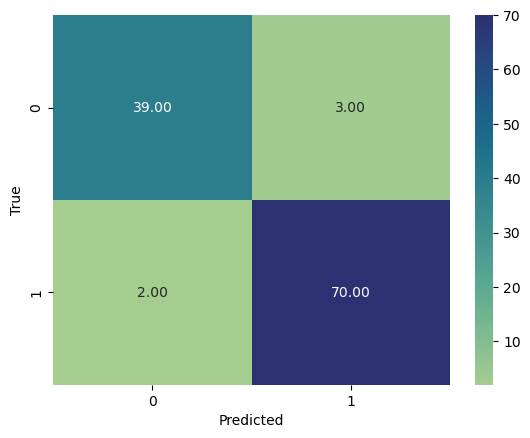

In [10]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".2f", cmap="crest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## AdaBoost

AdaBoost (Adaptive Boosting) is an ensemble learning method based on the principle of **boosting** — combining multiple **weak learners** (typically shallow decision trees) trained **sequentially**, where each model focuses more on the samples that were misclassified by previous ones.

### 1. Weighted samples initialization

All training examples start with equal weights:

$$
w_i^{(1)} = \frac{1}{N}, \quad i = 1, 2, \dots, N
$$

where  

* $N$ — total number of training samples,  
* $w_i^{(t)}$ — weight of sample $i$ at iteration $t$.

### 2. Sequential model training

At each iteration $t$, a weak model $h_t(x)$ is trained to minimize the **weighted error**:

$$
\varepsilon_t =
\frac{\sum_{i=1}^{N} w_i^{(t)} \,\mathbf{1}\!\left(h_t(x_i) \neq y_i\right)}
{\sum_{i=1}^{N} w_i^{(t)}}
$$

where $\mathbf{1}(\cdot)$ is the indicator function that equals 1 if the prediction is wrong.

The model’s importance (its contribution to the final ensemble) is then computed as:

$$
\alpha_t = \tfrac{1}{2}\,\ln\!\left(\frac{1 - \varepsilon_t}{\varepsilon_t}\right)
$$

### 3. Updating sample weights

After each iteration, the sample weights are updated — misclassified examples receive **more weight**, and correctly classified ones receive **less**:

$$
w_i^{(t+1)} = w_i^{(t)} \exp\!\left(-\alpha_t\, y_i\, h_t(x_i)\right)
$$

and then normalized:

$$
w_i^{(t+1)} \leftarrow
\frac{w_i^{(t+1)}}{\sum_{j=1}^{N} w_j^{(t+1)}}
$$

where $y_i, h_t(x_i) \in \{-1, +1\}$.

### 4. Final ensemble prediction

Once all $T$ weak models are trained, the final prediction is a **weighted vote** of all models:

$$
\hat{y} = \operatorname{sign}\!\left(\sum_{t=1}^{T} \alpha_t\, h_t(x)\right)
$$

where  

* $\alpha_t$ — weight (importance) of model $h_t$,  
* $T$ — total number of weak learners.

### Summary

AdaBoost adaptively reweights training examples so that each subsequent model focuses on the hardest-to-classify samples.  
By combining many weak learners, AdaBoost achieves **low bias**, **strong robustness**, and excellent performance even with **simple base models** (e.g., decision stumps of depth = 1).

In [11]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [12]:
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy: 95.61%
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



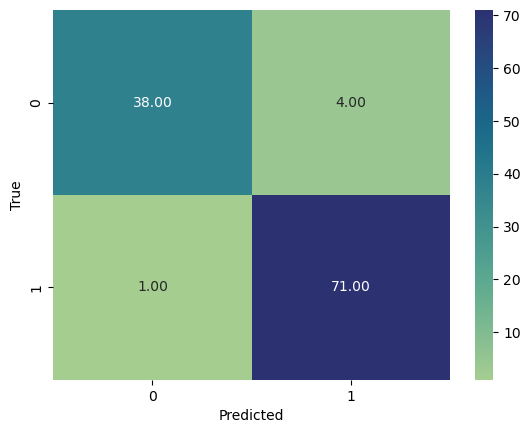

In [13]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".2f", cmap="crest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()